# Load libraries and set device up

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import torch.nn          as nn
import os
import torch
import json

from libraries.dataset      import generate_dataset, standardize_dataset
from libraries.model        import GCNN, train, test, EarlyStopping
from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [2]:
n_epochs      = 100
batch_size    = 128
learning_rate = 0.001
dropout       = 0.1
patience      = 10
delta         = 2
train_ratio   = 0.6
test_ratio    = 0.2  # val_ratio = 1 - train_ratio - test_ratio

dpi = 50

target = 'bandgap'
folder = 'bandgaps-MChX'

input_folder  = 'models'
target_folder = f'{input_folder}/{folder}'
model_name    = f'{target_folder}/{target}-model.pt'

# Generate or load graph database for training

In [3]:
labels_name                  = f'{target_folder}/labels.pt'
dataset_name                 = f'{target_folder}/dataset.pt'
dataset_name_std             = f'{target_folder}/standardized_dataset.pt'
labels_name_std              = f'{target_folder}/standardized_labels.pt'
standardized_parameters_name = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

if not any(os.path.exists(path) for path in [dataset_name_std, standardized_parameters_name, labels_name_std, dataset_name, labels_name]):
    # Generate data
    generate_dataset('/home/claudio/cibran/Work/UPC/CLUE/Loaded_PhaseTransition',
                     targets=['EPA', 'bandgap'],
                     data_folder=target_folder)

if all(os.path.exists(path) for path in [dataset_name_std, standardized_parameters_name, labels_name_std]):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset = torch.load(dataset_name_std)
    labels  = torch.load(labels_name_std)
    
    # Load the data from the JSON file
    with open(standardized_parameters_name, 'r') as json_file:
        numpy_dict = json.load(json_file)
    
    # Convert torch tensors to numpy arrays
    standardized_parameters = {}
    for key, value in numpy_dict.items():
        try:
            standardized_parameters[key] = torch.tensor(value)
        except:
            standardized_parameters[key] = value

elif all(os.path.exists(path) for path in [dataset_name, labels_name]):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name)
    labels  = torch.load(labels_name)
    
    # Standardize dataset
    dataset, labels, standardized_parameters = standardize_dataset(dataset, labels)
    
    # Save standardized dataset
    torch.save(dataset, dataset_name_std)
    torch.save(labels,  labels_name_std)
    
    # Convert torch tensors to numpy arrays
    numpy_dict = {}
    for key, value in standardized_parameters.items():
        try:
            numpy_dict[key] = value.cpu().numpy().tolist()
        except:
            numpy_dict[key] = value
    
    # Dump the dictionary with numpy arrays to a JSON file
    with open(standardized_parameters_name, 'w') as json_file:
        json.dump(numpy_dict, json_file)  

# Load the data from the JSON file
with open(f'{target_folder}/dataset_parameters.json', 'r') as json_file:
    dataset_parameters = json.load(json_file)

# Determine the index for the desired property
target_idx = [idx for idx, t in enumerate(dataset_parameters['database_target']) if t == target][0]
standardized_parameters['target_mean'] = standardized_parameters['target_mean'][target_idx]
standardized_parameters['target_std']  = standardized_parameters['target_std'][target_idx]

# Defining target factor
target_factor = standardized_parameters['target_std'] / standardized_parameters['scale']

# Select the target we want
for data in dataset:
    data.y = data.y[target_idx]

/tmp/ipykernel_244819/622853127.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_name_std)
/tmp/ipykernel_244819/622853127.py:16: FutureWarn

Split dataset

In [4]:
# Define the sizes of the train and test sets
# Corresponds to the size wrt the number of unique materials in the dataset
train_size = int(train_ratio * len(dataset))
test_size  = int(test_ratio  * len(dataset))

np.random.shuffle(dataset)

# Random, fast splitting
train_dataset = dataset[:train_size]
val_dataset   = dataset[train_size:-test_size]
test_dataset  = dataset[-test_size:]

del dataset  # Free up CUDA memory

print(f'Number of training   graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of testing    graphs: {len(test_dataset)}')

Number of training   graphs: 75
Number of validation graphs: 25
Number of testing    graphs: 25


Define data loaders.

In [5]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features

del train_dataset, val_dataset, test_dataset  # Free up CUDA memory

# Generate Graph Neural Network model

In [6]:
model = GCNN(features_channels=n_node_features,
                 pdropout=dropout)

# Moving model to device
model = model.to(device)

if os.path.exists(f'{target_folder}/{target}-model.pt'):
    model.load_state_dict(torch.load(f'{target_folder}/{target}-model.pt'), map_location=torch.device(device), weights_only=False)
    model.train()

# Allow data parallelization among multi-GPU
model= nn.DataParallel(model)
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(7, 512)
    (conv2): GraphConv(512, 512)
    (linconv1): Linear(in_features=512, out_features=64, bias=True)
    (linconv2): Linear(in_features=64, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion 

In [7]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = EarlyStopping(patience=patience, delta=delta, model_name=model_name)

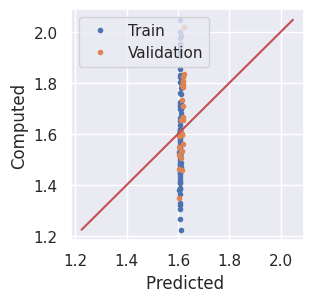

Epoch: 1, Train MAE: 0.1882, Val MAE: 0.1472
Epoch: 2, Train MAE: 0.1834, Val MAE: 0.1408
Epoch: 3, Train MAE: 0.1777, Val MAE: 0.1338
Epoch: 4, Train MAE: 0.1714, Val MAE: 0.1265
Epoch: 5, Train MAE: 0.1641, Val MAE: 0.1193


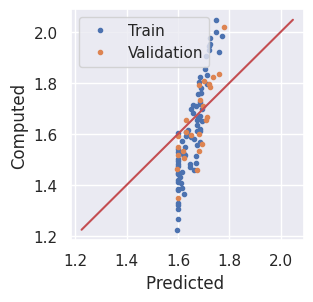

Epoch: 6, Train MAE: 0.1564, Val MAE: 0.1124
Epoch: 7, Train MAE: 0.1476, Val MAE: 0.1055
Epoch: 8, Train MAE: 0.1395, Val MAE: 0.0987
Epoch: 9, Train MAE: 0.1313, Val MAE: 0.0923
Epoch: 10, Train MAE: 0.1252, Val MAE: 0.0858


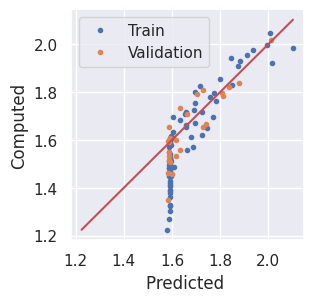

Epoch: 11, Train MAE: 0.1216, Val MAE: 0.0806
Epoch: 12, Train MAE: 0.1200, Val MAE: 0.0781
Epoch: 13, Train MAE: 0.1182, Val MAE: 0.0778
Epoch: 14, Train MAE: 0.1167, Val MAE: 0.0778
Epoch: 15, Train MAE: 0.1131, Val MAE: 0.0775


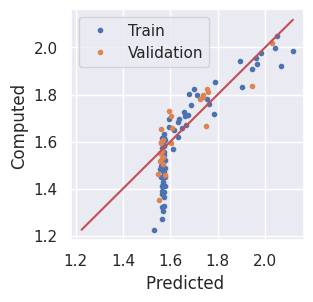

Epoch: 16, Train MAE: 0.1085, Val MAE: 0.0774
Epoch: 17, Train MAE: 0.1034, Val MAE: 0.0766
Epoch: 18, Train MAE: 0.0971, Val MAE: 0.0757
Epoch: 19, Train MAE: 0.0933, Val MAE: 0.0748
Epoch: 20, Train MAE: 0.0877, Val MAE: 0.0736


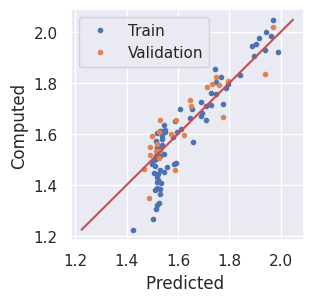

Epoch: 21, Train MAE: 0.0834, Val MAE: 0.0719
Epoch: 22, Train MAE: 0.0771, Val MAE: 0.0704
Epoch: 23, Train MAE: 0.0731, Val MAE: 0.0709
Epoch: 24, Train MAE: 0.0670, Val MAE: 0.0726
Epoch: 25, Train MAE: 0.0643, Val MAE: 0.0752


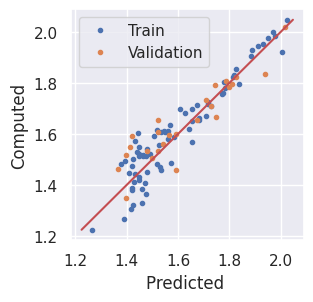

Epoch: 26, Train MAE: 0.0632, Val MAE: 0.0754
Epoch: 27, Train MAE: 0.0605, Val MAE: 0.0723
Epoch: 28, Train MAE: 0.0593, Val MAE: 0.0678
Epoch: 29, Train MAE: 0.0570, Val MAE: 0.0623
Epoch: 30, Train MAE: 0.0546, Val MAE: 0.0559


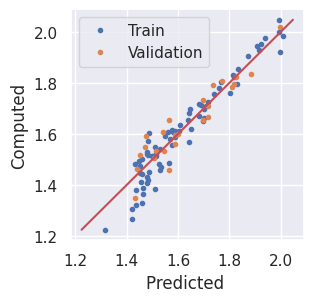

Epoch: 31, Train MAE: 0.0544, Val MAE: 0.0530
Epoch: 32, Train MAE: 0.0549, Val MAE: 0.0510
Epoch: 33, Train MAE: 0.0473, Val MAE: 0.0509
Epoch: 34, Train MAE: 0.0458, Val MAE: 0.0527
Epoch: 35, Train MAE: 0.0427, Val MAE: 0.0528


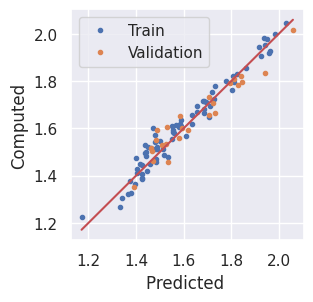

Epoch: 36, Train MAE: 0.0407, Val MAE: 0.0513
Epoch: 37, Train MAE: 0.0372, Val MAE: 0.0492
Epoch: 38, Train MAE: 0.0350, Val MAE: 0.0417
Epoch: 39, Train MAE: 0.0369, Val MAE: 0.0412
Epoch: 40, Train MAE: 0.0335, Val MAE: 0.0442


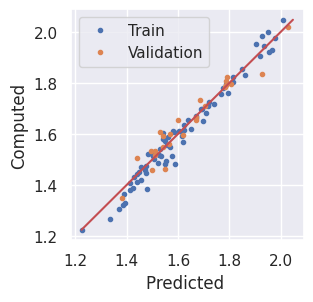

Epoch: 41, Train MAE: 0.0349, Val MAE: 0.0411
Epoch: 42, Train MAE: 0.0317, Val MAE: 0.0445
Epoch: 43, Train MAE: 0.0301, Val MAE: 0.0509
Epoch: 44, Train MAE: 0.0331, Val MAE: 0.0429
Epoch: 45, Train MAE: 0.0332, Val MAE: 0.0428


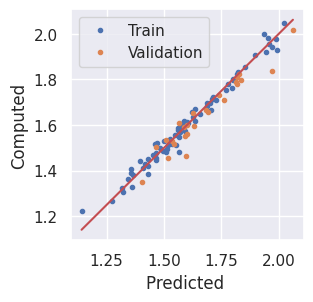

Epoch: 46, Train MAE: 0.0276, Val MAE: 0.0499
Epoch: 47, Train MAE: 0.0324, Val MAE: 0.0392
Epoch: 48, Train MAE: 0.0295, Val MAE: 0.0382
Epoch: 49, Train MAE: 0.0290, Val MAE: 0.0417
Epoch: 50, Train MAE: 0.0282, Val MAE: 0.0413


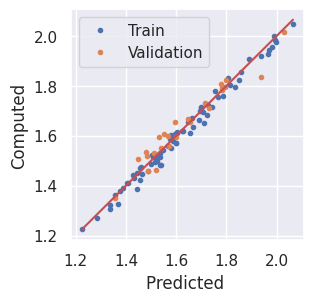

Epoch: 51, Train MAE: 0.0234, Val MAE: 0.0383
Epoch: 52, Train MAE: 0.0264, Val MAE: 0.0390
Epoch: 53, Train MAE: 0.0210, Val MAE: 0.0463
Epoch: 54, Train MAE: 0.0274, Val MAE: 0.0390
Epoch: 55, Train MAE: 0.0225, Val MAE: 0.0396


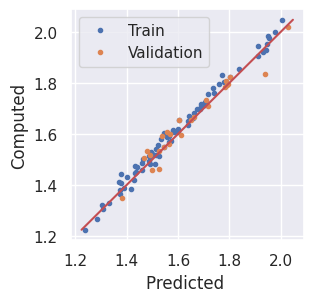

Epoch: 56, Train MAE: 0.0267, Val MAE: 0.0363
Epoch: 57, Train MAE: 0.0247, Val MAE: 0.0409
Epoch: 58, Train MAE: 0.0305, Val MAE: 0.0356
Epoch: 59, Train MAE: 0.0230, Val MAE: 0.0363
Epoch: 60, Train MAE: 0.0231, Val MAE: 0.0354


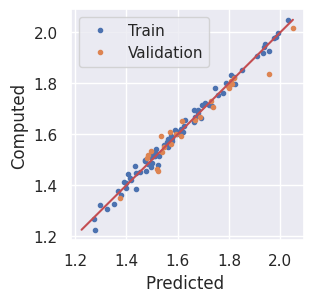

Epoch: 61, Train MAE: 0.0199, Val MAE: 0.0375
Epoch: 62, Train MAE: 0.0216, Val MAE: 0.0357
Epoch: 63, Train MAE: 0.0191, Val MAE: 0.0343
Epoch: 64, Train MAE: 0.0220, Val MAE: 0.0332
Epoch: 65, Train MAE: 0.0208, Val MAE: 0.0334


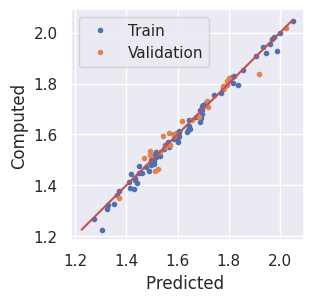

Epoch: 66, Train MAE: 0.0201, Val MAE: 0.0314
Epoch: 67, Train MAE: 0.0223, Val MAE: 0.0314
Epoch: 68, Train MAE: 0.0183, Val MAE: 0.0324
Epoch: 69, Train MAE: 0.0189, Val MAE: 0.0327
Epoch: 70, Train MAE: 0.0182, Val MAE: 0.0332


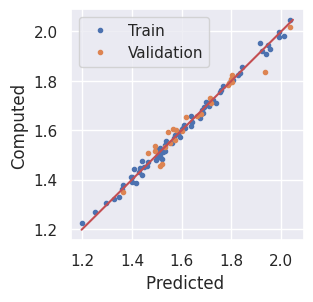

Epoch: 71, Train MAE: 0.0160, Val MAE: 0.0334
Epoch: 72, Train MAE: 0.0195, Val MAE: 0.0335
Epoch: 73, Train MAE: 0.0156, Val MAE: 0.0336
Epoch: 74, Train MAE: 0.0147, Val MAE: 0.0339
Epoch: 75, Train MAE: 0.0171, Val MAE: 0.0338


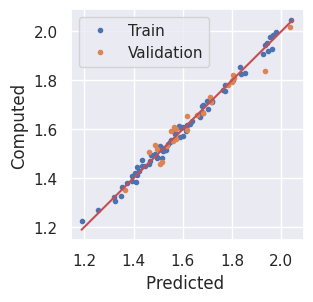

Epoch: 76, Train MAE: 0.0164, Val MAE: 0.0335
Epoch: 77, Train MAE: 0.0191, Val MAE: 0.0331
Epoch: 78, Train MAE: 0.0153, Val MAE: 0.0335
Epoch: 79, Train MAE: 0.0172, Val MAE: 0.0331
Epoch: 80, Train MAE: 0.0157, Val MAE: 0.0315


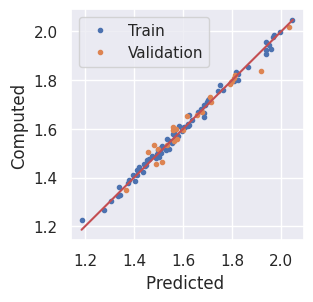

Epoch: 81, Train MAE: 0.0161, Val MAE: 0.0309
Epoch: 82, Train MAE: 0.0155, Val MAE: 0.0307
Epoch: 83, Train MAE: 0.0155, Val MAE: 0.0305
Epoch: 84, Train MAE: 0.0160, Val MAE: 0.0306
Epoch: 85, Train MAE: 0.0163, Val MAE: 0.0301


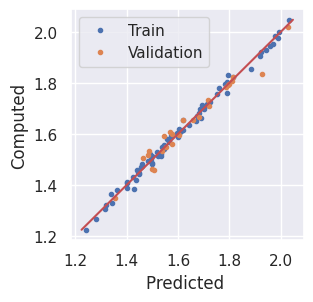

Epoch: 86, Train MAE: 0.0155, Val MAE: 0.0304
Epoch: 87, Train MAE: 0.0172, Val MAE: 0.0318
Epoch: 88, Train MAE: 0.0163, Val MAE: 0.0312
Epoch: 89, Train MAE: 0.0137, Val MAE: 0.0302
Epoch: 90, Train MAE: 0.0145, Val MAE: 0.0299


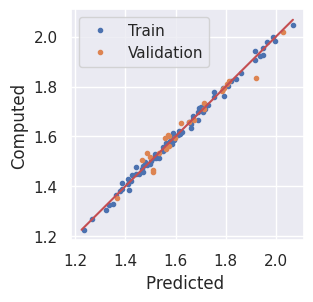

Epoch: 91, Train MAE: 0.0136, Val MAE: 0.0296
Epoch: 92, Train MAE: 0.0143, Val MAE: 0.0297
Epoch: 93, Train MAE: 0.0143, Val MAE: 0.0300
Epoch: 94, Train MAE: 0.0161, Val MAE: 0.0302
Epoch: 95, Train MAE: 0.0147, Val MAE: 0.0306


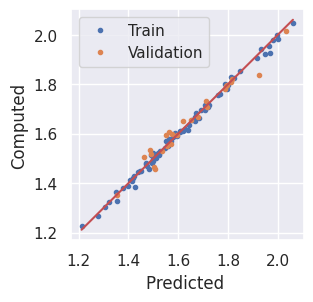

Epoch: 96, Train MAE: 0.0131, Val MAE: 0.0304
Epoch: 97, Train MAE: 0.0133, Val MAE: 0.0305
Epoch: 98, Train MAE: 0.0124, Val MAE: 0.0299
Epoch: 99, Train MAE: 0.0149, Val MAE: 0.0295
Epoch: 100, Train MAE: 0.0144, Val MAE: 0.0291


In [8]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = train(model, criterion, train_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device),
                                                               optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  test(model, criterion, val_loader,
                                                               target_factor.to(device),
                                                               standardized_parameters['target_mean'].to(device))

    # Pass to energy units (same as initial Fv)
    train_loss = np.sqrt(train_loss) * target_factor.item()
    val_loss   = np.sqrt(val_loss)   * target_factor.item()

    if epoch%5 == 0:
        stack = np.concatenate([train_predictions, train_ground_truths,
                                val_predictions,   val_ground_truths])
    
        _min_ = np.min(stack)
        _max_ = np.max(stack)
    
        plt.figure(figsize=(3, 3))
        plt.plot(train_predictions, train_ground_truths, '.', label='Train')
        plt.plot(val_predictions,   val_ground_truths,   '.', label='Validation')
        plt.xlabel(r'Predicted ')
        plt.ylabel(r'Computed')
        plt.plot([_min_, _max_], [_min_, _max_], '-r')
        plt.legend(loc='best')
        plt.show()
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

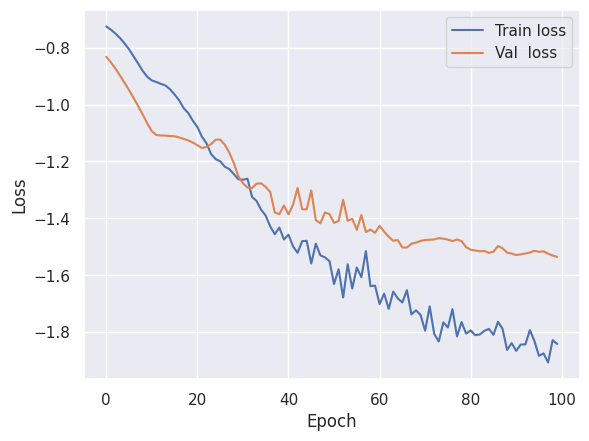

In [9]:
plt.plot(np.log10(train_losses), label='Train loss')
plt.plot(np.log10(val_losses) , label='Val  loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Check test data

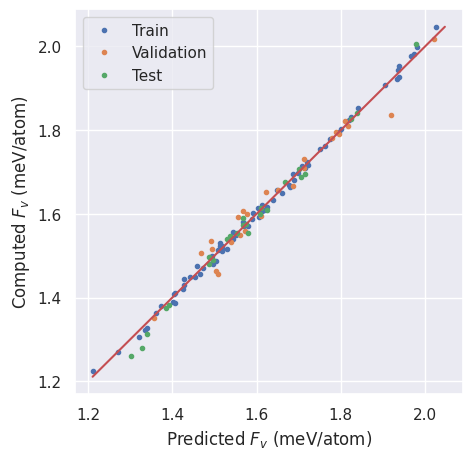

Train MAE: 0.0097, Val MAE: 0.0291, Test MAE: 0.0182


In [10]:
train_loss, train_predictions, train_ground_truths = test(model, criterion, train_loader,
                                                          target_factor.to(device),
                                                          standardized_parameters['target_mean'].to(device))
val_loss,   val_predictions,   val_ground_truths   =  test(model, criterion, val_loader,
                                                           target_factor.to(device),
                                                           standardized_parameters['target_mean'].to(device))
test_loss,  test_predictions,  test_ground_truths  =  test(model, criterion, test_loader,
                                                           target_factor.to(device),
                                                           standardized_parameters['target_mean'].to(device))

# Pass to energy units (same as initial Fv)
train_loss = np.sqrt(train_loss) * target_factor.item()
val_loss   = np.sqrt(val_loss)   * target_factor.item()
test_loss  = np.sqrt(test_loss)  * target_factor.item()

stack = np.concatenate([train_predictions, train_ground_truths,
                        val_predictions,   val_ground_truths,
                        test_predictions,  test_ground_truths])

_min_ = np.min(stack)
_max_ = np.max(stack)

plt.figure(figsize=(5, 5))
plt.plot(train_predictions, train_ground_truths, '.', label='Train')
plt.plot(val_predictions,   val_ground_truths,   '.', label='Validation')
plt.plot(test_predictions,  test_ground_truths,  '.', label='Test')
plt.xlabel(r'Predicted $F_v$ (meV/atom)')
plt.ylabel(r'Computed $F_v$ (meV/atom)')
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.legend(loc='best')
plt.savefig(f'{target_folder}/{target}-GCNN-training.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

In [45]:
dataset = torch.load(dataset_name_std)
labels  = torch.load(labels_name_std)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

loss, predictions, ground_truths = test(model, criterion, loader,
                                        target_factor.to(device),
                                        standardized_parameters['target_mean'].to(device))

uncertainties = ground_truths - predictions
uncertainties

/tmp/ipykernel_244819/1932628653.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_name_std)
/tmp/ipykernel_244819/1932628653.py:2: FutureWarn

In [64]:
# Generate dictionnary with uncertinty data
# label: uncertainty = ground-truth - prediction
uncertainty_data = {}
for idx, label in enumerate(labels):
    uncertainty_data.update(
        {label: float(uncertainties[idx])}
    )

# Dump the dictionary with numpy arrays to a JSON file
with open(f'{target_folder}/uncertainty_data.json', 'w') as json_file:
    json.dump(uncertainty_data, json_file)  